In [95]:
import torch
import torchvision
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)

use_cuda = torch.cuda.is_available()
print('use_cuda:', use_cuda)

batch_size = 32 # batch size
n_epoches = 100 # Maximum number of epoches

torch: 0.4.0
torchvision: 0.2.1
use_cuda: False


# CIFAR dataset

- Classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
- Image size: 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Load and normalizing the CIFAR10 training and test datasets 

In [96]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset

# Normalized range [-1, 1]; mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_classes = len(classes)

trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='data', train=False, download=False, transform=transform)

# 테스트 목적으로 일부 데이터만 사용한다
trainset = Subset(trainset, range(1000))
testset = Subset(testset, range(200))

Files already downloaded and verified


## Exploring the dataset

Populating the interactive namespace from numpy and matplotlib
The number of training data: 1000
The number of test data: 200
Image size: torch.Size([3, 32, 32]), class: frog(6) of the first training data


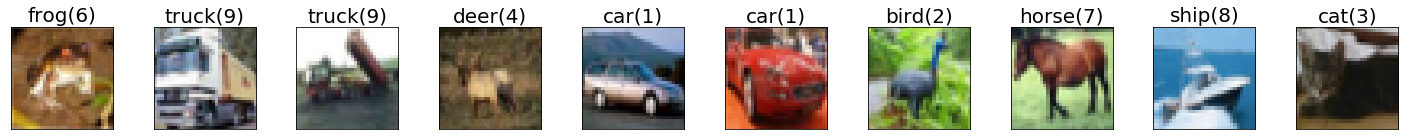

In [97]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print('The number of training data:', len(trainset))
print('The number of test data:', len(testset))
print('Image size: %s, class: %s(%s) of the first training data' % 
      (trainset[0][0].size(), classes[trainset[0][1]], trainset[0][1]))

# show images
images = [trainset[i][0] for i in range(10)]
cls_indices = [trainset[i][1] for i in range(10)]
fig, axes = plt.subplots(nrows=1, ncols=10)
fig.set_figwidth(20)
fig.set_figheight(7)
plt.tight_layout(w_pad=1)
for i in range(10):
    npimg = images[i].numpy()
    npimg = np.transpose(npimg, (1,2,0))
    npimg = npimg/2 + 0.5 # unnormalize
    axes[i].imshow(npimg)
    axes[i].set_title('%s(%s)' % (classes[cls_indices[i]], cls_indices[i]), {'fontsize': 20})
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

Populating the interactive namespace from numpy and matplotlib


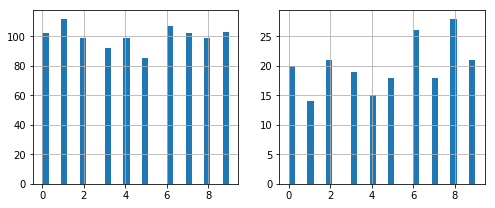

In [130]:
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(7)
fig.set_figheight(3)
plt.tight_layout(w_pad=1)

# Check the class distribution of train/test datasets 
train_cls_indices = [trainset[i][1] for i in range(len(trainset))]
test_cls_indices = [testset[i][1] for i in range(len(testset))]

pd.Series(train_cls_indices).hist(ax=axes[0], bins=30)
pd.Series(test_cls_indices).hist(ax=axes[1], bins=30)

# VGG-like ConvNet architecture

In [112]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class VGGNet(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), 
                 layer_cfg=[32, 32, 'M', 64, 64, 'M'], 
                 batch_norm=False): 
        super(VGGNet, self).__init__()    
        
        self.input_shape = input_shape
        self.batch_norm = batch_norm
        self.feature_extractor = self._make_conv_layers(layer_cfg)
        self.classifier = nn.Sequential(
            nn.Linear(self._get_flatten_size(), 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _get_flatten_size(self, batch_size=1):
        out = self.feature_extractor(Variable(torch.rand(batch_size, *self.input_shape)))
        return out.data.view(batch_size, -1).size(1)  
    
    def _make_conv_layers(self, layer_cfg):
        layers = []
        in_channels = self.input_shape[0]
        for v in layer_cfg:
            if v != 'M':
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if self.batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
            else:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)

In [35]:
model = VGGNet()
model

VGGNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

# ModelTrainer

In [118]:
import torch.nn
import torch.optim

def get_output_labels(outputs):
    _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy() if use_cuda else preds.numpy()

class ModelTrainer(object):
    def __init__(self, model=None):
        self.model = model
        # train listeners for observing a training process
        self.train_listeners = []

    def fit(self, trainloader, testloader, init_weights=True, n_epoches=n_epoches):
        # for early stopping
        self.stop_training = False
        optimizer = torch.optim.Adam(self.model.parameters())
        criterion = nn.CrossEntropyLoss()
        
        # Callback parameters
        params = {}
        params['model'] = self.model
        params['optimizer']  = optimizer
        params['criterion']  = criterion
        params['n_epoches']  = n_epoches
        
        if init_weights:
            self._initialize_weights()
            print('Model weights were initialized.')
        
        print('Begin training...')
#         print(params)        
        self._fire_train_begin(params)
        
        for epoch in range(n_epoches):
            if not self.stop_training:
                print('--------------------')
                print('Begin epoch %s/%s' % (epoch + 1, n_epoches))
                params['epoch'] = epoch
                self._fire_epoch_begin(params)

                # Train phase
                print('Begin training at epoch %s/%s' % (epoch + 1, n_epoches))
                self.model.train()
                params['phase'] = 'train'
                params['batch_size'] = trainloader.batch_size

                for bi, (inputs, targets) in enumerate(trainloader):
                    begin = bi * trainloader.batch_size
                    end = begin + trainloader.batch_size
#                     print('Current batch %s in train phase, %s:%s' % (bi + 1, begin, end))
                    
                    params['batch_index'] = bi
                    params['targets'] = targets.cpu().numpy() if use_cuda else targets.numpy()
                    
                    self._fire_batch_begin(params)

                    if use_cuda:
                        inputs = inputs.cuda()
                        targets = targets.cuda()

                    # Forward
                    optimizer.zero_grad()                
                    outputs = self.model(inputs)
                    loss = criterion(outputs, targets)

                    # Backpropagation
                    loss.backward()
                    optimizer.step()  
                    
                    params['outputs'] = get_output_labels(outputs)
                    params['loss'] = loss.data[0].cpu().numpy() if use_cuda else loss.data[0].numpy()
#                     print('target:', params['targets'], 'outputs:', params['outputs'], 'loss:', params['loss'])
                    self._fire_batch_end(params)
                print('End training at epoch %s/%s' % (epoch + 1, n_epoches))
                
                # Validation phase
                print('Begin validation at epoch %s/%s' % (epoch + 1, n_epoches))
                self.model.eval()
                params['phase'] = 'val'
                params['batch_size'] = testloader.batch_size                
                for bi, (inputs, targets) in enumerate(testloader):
                    begin = bi * testloader.batch_size
                    end = begin + testloader.batch_size
#                     print('Current batch %s in val phase, %s:%s' % (bi + 1, begin, end))
                    
                    params['batch_index'] = bi
                    params['targets'] = targets.cpu().numpy() if use_cuda else targets.numpy()
                    
                    self._fire_batch_begin(params)
                    
                    if use_cuda:
                        inputs = inputs.cuda()
                        targets = targets.cuda()
                    
                    # Forward
                    optimizer.zero_grad()                
                    outputs = self.model(inputs)
                    loss = criterion(outputs, targets)

                    params['outputs'] = get_output_labels(outputs)
                    params['loss'] = loss.data[0].cpu().numpy() if use_cuda else loss.data[0].numpy()
#                     print('target:', params['targets'], 'outputs:', params['outputs'], 'loss:', params['loss'])
                    self._fire_batch_end(params)
                
                print('End validation at epoch %s/%s' % (epoch + 1, n_epoches))
                
                self._fire_epoch_end(params)
                print('End epoch %s/%s' % (epoch + 1, n_epoches))
                print('--------------------')
        
        self._fire_train_end(params)
        print('Training completed.')        
        print('======================')   
    
    
    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def add_train_listener(self, listener):
        self.train_listeners.append(listener)

    def _fire_train_begin(self, params=None):
        for train_listener in self.train_listeners:
            train_listener.on_train_begin(self, params)

    def _fire_train_end(self, params=None):
        for train_listener in self.train_listeners:
            train_listener.on_train_end(self, params)

    def _fire_epoch_begin(self, params=None):
        for train_listener in self.train_listeners:
            train_listener.on_epoch_begin(self, params)
            
    def _fire_epoch_end(self, params=None):
        for train_listener in self.train_listeners:
            train_listener.on_epoch_end(self, params)
            
    def _fire_batch_begin(self, params=None):
        for train_listener in self.train_listeners:
            train_listener.on_batch_begin(self, params)

    def _fire_batch_end(self, params=None):
        for train_listener in self.train_listeners:
            train_listener.on_batch_end(self, params)

In [120]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model_trainer = ModelTrainer(model=model)
model_trainer.fit(trainloader=trainloader, testloader=testloader, n_epoches=1)

Model weights were initialized.
Begin training...
--------------------
Begin epoch 1/1
Begin training at epoch 1/1
End training at epoch 1/1
Begin validation at epoch 1/1
End validation at epoch 1/1
End epoch 1/1
--------------------
Training completed.


# TrainListener
- ModelTrainer가 모델을 훈련시키는 과정동안 발생하는 이벤트를 받아 처리하는 observer 클래스

In [121]:
class TrainListener(object):

    def on_train_begin(self, trainer, params):
        pass
    
    def on_train_end(self, trainer, params):
        pass
    
    def on_epoch_begin(self, trainer, params):
        pass
    
    def on_epoch_end(self, trainer, params):
        pass
    
    def on_batch_begin(self, trainer, params):
        pass
    
    def on_batch_end(self, trainer, params):
        pass

# ModelEvaluator
- 다양한 성능 평가 metric을 사용하여 모델의 예측 성능을 측정한다.

In [58]:
import collections
from sklearn.metrics import *
from scipy.stats import spearmanr

class ModelEvaluator(object):
    
    def __init__(self, metrics=['accuracy']):
        self.scorer_map = self._create_scorer_map(metrics)
    
    def score_map(self, y_true, y_pred):
        result = {}
        for m, scorer in self.scorer_map.items():
            result[m] = scorer(y_true, y_pred)
        return result
    
    def metrices(self):
        return self.scorer_map.keys()        
    
    def _create_scorer_map(self, metrics):
        scorer_map = collections.OrderedDict()
        for m in metrics:
            if m == 'accuracy':
                scorer_map[m] = lambda y_true, y_pred: accuracy_score(y_true, y_pred)
            elif m == 'roc_auc':
                scorer_map[m] = lambda y_true, y_pred: roc_auc_score(y_true, y_pred)
            elif m == 'f1':
                scorer_map[m] = lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
            elif m == 'srcc': # Spearman correlation
                scorer_map[m] = lambda y_true, y_pred: spearmanr(y_true, y_pred, axis=0)[0]
            else:
                raise NotImplementedError('Not implemented metric yet:', m)
        return scorer_map
    
model_evaluator = ModelEvaluator(metrics=['accuracy', 'f1'])
model_evaluator.score_map(y_true=[1, 2, 0, 3], y_pred= [1, 0, 0, 3])

{'accuracy': 0.75, 'f1': 0.6666666666666666}

# LossRecoder

In [122]:
class LossRecoder(TrainListener):
    
    def on_train_begin(self, trainer, params):
        self.train_losses = []
        self.val_losses = []

    def on_epoch_begin(self, trainer, params):
        self.epoch_train_losses = []
        self.epoch_val_losses = []
        
    def on_epoch_end(self, trainer, params):
        self.train_losses.append(np.mean(self.epoch_train_losses))
        self.val_losses.append(np.mean(self.epoch_val_losses))
     
    def on_batch_end(self, trainer, params):
        phase = params['phase']
        loss = params['loss']
        if phase == 'train':
            self.epoch_train_losses.append(loss)
        else:
            self.epoch_val_losses.append(loss)

Populating the interactive namespace from numpy and matplotlib
Model weights were initialized.
Begin training...
--------------------
Begin epoch 1/10
Begin training at epoch 1/10
End training at epoch 1/10
Begin validation at epoch 1/10
End validation at epoch 1/10
End epoch 1/10
--------------------
--------------------
Begin epoch 2/10
Begin training at epoch 2/10
End training at epoch 2/10
Begin validation at epoch 2/10
End validation at epoch 2/10
End epoch 2/10
--------------------
--------------------
Begin epoch 3/10
Begin training at epoch 3/10
End training at epoch 3/10
Begin validation at epoch 3/10
End validation at epoch 3/10
End epoch 3/10
--------------------
--------------------
Begin epoch 4/10
Begin training at epoch 4/10
End training at epoch 4/10
Begin validation at epoch 4/10
End validation at epoch 4/10
End epoch 4/10
--------------------
--------------------
Begin epoch 5/10
Begin training at epoch 5/10
End training at epoch 5/10
Begin validation at epoch 5/10
En

Text(0.5,0,'Epoch')

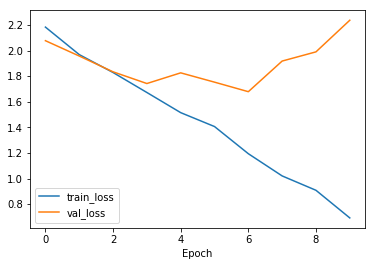

In [124]:
%pylab inline

import pandas as pd

model_trainer = ModelTrainer(model=model)
loss_recoder = LossRecoder()
model_trainer.add_train_listener(loss_recoder)
model_trainer.fit(trainloader=trainloader, testloader=testloader, n_epoches=10)

df = pd.DataFrame(data={'train_loss': loss_recoder.train_losses, 'val_loss': loss_recoder.val_losses})
ax = df.plot()
ax.set_xlabel('Epoch')

# EarlyStopper

In [126]:
class EarlyStopper(TrainListener):

    def __init__(self, loss_recoder=None, patience=0):
        self.loss_recoder = loss_recoder
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0

    def on_train_begin(self, trainer, params):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        
    def on_epoch_end(self, trainer, params):
        epoch = params['epoch']
        n_epoches = params['n_epoches']
        current = self.loss_recoder.val_losses[-1]
        
        if current < self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            print('[EarlyStopper]: In epoch %s/%s, increase wait count: %s due to best: %s, current: %s' %
                  (epoch, n_epoches, self.wait, self.best, current))

            if self.wait >= self.patience:
                self.stopped_epoch = params['epoch']
                trainer.stop_training = True
                
                print('[EarlyStopper]: Early stopping training: wait %s >= patience %s at epoch %s/%s' % 
                      (self.wait, self.patience, epoch, n_epoches))

    def on_train_end(self, trainer, params):
        n_epoches = params['n_epoches']
        if self.stopped_epoch > 0 and self.stopped_epoch < (n_epoches - 1):
            print('[EarlyStopper]: Early stopped at the epoch %s/%s' % (self.stopped_epoch + 1, n_epoches))

In [127]:
model_trainer = ModelTrainer(model=model)
loss_recoder = LossRecoder()
model_trainer.add_train_listener(loss_recoder)
model_trainer.add_train_listener(EarlyStopper(loss_recoder=loss_recoder, patience=2))
model_trainer.fit(trainloader=trainloader, testloader=testloader, n_epoches=10)

Model weights were initialized.
Begin training...
--------------------
Begin epoch 1/10
Begin training at epoch 1/10
End training at epoch 1/10
Begin validation at epoch 1/10
End validation at epoch 1/10
End epoch 1/10
--------------------
--------------------
Begin epoch 2/10
Begin training at epoch 2/10
End training at epoch 2/10
Begin validation at epoch 2/10
End validation at epoch 2/10
End epoch 2/10
--------------------
--------------------
Begin epoch 3/10
Begin training at epoch 3/10
End training at epoch 3/10
Begin validation at epoch 3/10
End validation at epoch 3/10
End epoch 3/10
--------------------
--------------------
Begin epoch 4/10
Begin training at epoch 4/10
End training at epoch 4/10
Begin validation at epoch 4/10
End validation at epoch 4/10
End epoch 4/10
--------------------
--------------------
Begin epoch 5/10
Begin training at epoch 5/10
End training at epoch 5/10
Begin validation at epoch 5/10
End validation at epoch 5/10
End epoch 5/10
--------------------


# ModelCheckpoint
- Epoch 단위로 학습된 모델을 저장한다.

In [76]:
class ModelCheckpoint(TrainListener):
    
    def __init__(self, loss_recoder=None, filepath=None, period=1, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.loss_recoder = loss_recoder
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.period = period
        self.epochs_since_last_save = 0
        self.best = np.Inf
        self.fn_best = None
        
    def on_train_begin(self, trainer, params):
        self.epochs_since_last_save = 0
        self.best = np.Inf
        self.fn_best = None
    
    def on_epoch_end(self, trainer, params):
        epoch = params['epoch']
        model = params['model']
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(**params)
            if self.save_best_only:
                current = self.loss_recoder.val_losses[-1]
                if current < self.best:
                    print('[ModelCheckpoint]: Checkpoint at epoch %s: val_loss improved from %s to %s, '
                          'saving model to %s' % (epoch + 1, self.best, current, filepath))
                    self.best = current
                    self._save_model(model, filepath)
                    self.fn_best = filepath
                    self._best_epoch = epoch
                else:
                    print('[ModelCheckpoint]: Checkpoint at epoch %s: val_loss did not improve' % (epoch + 1))
            else:
                print('[ModelCheckpoint]: Checkpoint at epoch %s: saving model to %s' % (epoch + 1, filepath))
                self._save_model(model, filepath)
                
    def _save_model(self, model, filepath):
        torch.save(model.state_dict(), filepath)
    
    @property
    def best_model_state(self):
        return self.fn_best, torch.load(self.fn_best)
    
    @property
    def best_epoch(self):
        return self._best_epoch
    
    @property
    def best_score(self):
        return self.best

In [128]:
model_trainer = ModelTrainer(model=model)
loss_recoder = LossRecoder()
model_trainer.add_train_listener(loss_recoder)
model_trainer.add_train_listener(EarlyStopper(loss_recoder=loss_recoder, patience=2))
model_cp = ModelCheckpoint(loss_recoder=loss_recoder, filepath='test_model_{epoch}.wts')
model_trainer.add_train_listener(model_cp)
model_trainer.fit(trainloader=trainloader, testloader=testloader, n_epoches=10)

print('Best model at epoch %s: %s, %s' % (model_cp.best_epoch, 
                                          model_cp.best_model_state[0], 
                                          model_cp.best_score))

Model weights were initialized.
Begin training...
--------------------
Begin epoch 1/10
Begin training at epoch 1/10
End training at epoch 1/10
Begin validation at epoch 1/10
End validation at epoch 1/10
[ModelCheckpoint]: Checkpoint at epoch 1: val_loss improved from inf to 2.2771084, saving model to test_model_0.wts
End epoch 1/10
--------------------
--------------------
Begin epoch 2/10
Begin training at epoch 2/10
End training at epoch 2/10
Begin validation at epoch 2/10
End validation at epoch 2/10
[ModelCheckpoint]: Checkpoint at epoch 2: val_loss improved from 2.2771084 to 1.972872, saving model to test_model_1.wts
End epoch 2/10
--------------------
--------------------
Begin epoch 3/10
Begin training at epoch 3/10
End training at epoch 3/10
Begin validation at epoch 3/10
End validation at epoch 3/10
[ModelCheckpoint]: Checkpoint at epoch 3: val_loss improved from 1.972872 to 1.9339819, saving model to test_model_2.wts
End epoch 3/10
--------------------
--------------------
B

# Prediction test of the best model

In [129]:
import torch

final_model = VGGNet()
final_model.load_state_dict(torch.load(model_cp.best_model_state[0]))

it = iter(testloader)
input_imgs, input_indices = it.next()

final_model.eval()
outputs = final_model(input_imgs)
pred_indices = get_output_labels(outputs)
print('Inputs:     ', input_indices.numpy())
print('Predictions:', pred_indices)

Inputs:      [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5]
Predictions: [3 1 1 8 4 6 1 4 3 1 0 1 4 1 1 7 5 1 1 4 7 0 8 1 7 6 6 7 1 6 6 2]
